# Import Libraries
Import the necessary libraries for this project.

In [7]:
# Import the necessary libraries.
import os
import numpy as np
from matplotlib import pyplot as plt, image as mpimg
import seaborn as sns
%matplotlib inline
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D 
import kerastuner as kt
from kerastuner import HyperModel
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, classification_report




print('All libraries are imported and ready to use!')

All libraries are imported and ready to use!


In [13]:
# Check tensorflow and keras version.
print("Tensorflow version", tf.__version__)
print("Keras version", keras.__version__)


# Reproducability
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed(66)

Tensorflow version 2.15.0
Keras version 3.3.3


# Explore the Image data.

There are 2 classes of images to be classify, which are: the presence of diabetic retinopathy [DR] and the absence of diabetic retinopathy [No_DR]



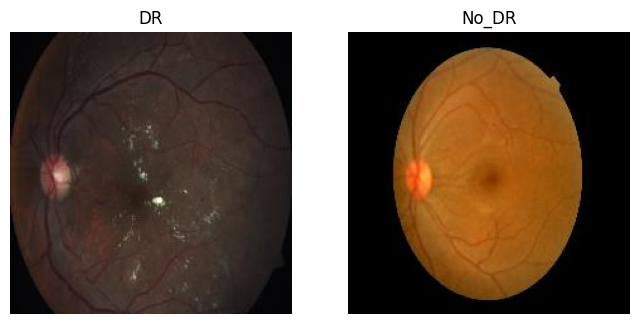

In [14]:
# The images are located in the data path.
train_data_path = "/kaggle/input/diagnosis-of-diabetic-retinopathy/train"

# Get the classes of images to be classified.
classes = os.listdir(train_data_path)
print(f"There are {len(classes)} classes of images to be classify, which are: the presence of diabetic retinopathy [{classes[0]}]" +
      f" and the absence of diabetic retinopathy [{classes[1]}]\n")


# Display the classes of images to be classified.
fig = plt.figure(figsize=(8, 10))

# Initialize the subplot index.
i = 0

for sub_directory in os.listdir(train_data_path):
    i += 1

    # Get the file path of the first image in each directory.
    image_path = os.listdir(os.path.join(train_data_path, sub_directory))[0]
    image_file = os.path.join(train_data_path, sub_directory, image_path)

    # Read the image file using matplotlib image module.
    image = mpimg.imread(image_file)

    # Add a subplot for each class and display the image.
    ax= fig.add_subplot(1, len(classes), i)
    ax.axis("off")
    ax.set_title(f"{sub_directory}")

    plt.imshow(image)

In [15]:
# Check the dimensions of the image.
for sub_directory in os.listdir(train_data_path):
    i += 1

    # Get the file path of the first image in each directory.
    image_path = os.listdir(os.path.join(train_data_path, sub_directory))[0]
    image_file = os.path.join(train_data_path, sub_directory, image_path)

    # Open the image file using PIL.
    image = Image.open(image_file)

    # Get the width and height of the image.
    width = image.width
    height = image.height

    # Print the width and height of the image.
    print(f"The width and height of the {sub_directory} image are {width} and {height} pixels respectively.")

The width and height of the DR image are 224 and 224 pixels respectively.
The width and height of the No_DR image are 224 and 224 pixels respectively.


# Prepare and Load the image data.
Load the image data for training of models, validating and evaluation of models.

In [6]:

# Get the validation directory.
val_data_path = "/kaggle/input/diagnosis-of-diabetic-retinopathy/valid"

print("Getting Data...")

# ImageDataGenerator for training data with data augmentation.
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    horizontal_flip = True, 
    vertical_flip = True
)

print("Preparing Training Dataset...")

# Define batxch size.
batch_size = 50

# Flow training images in batches using train_datagen.
train_generator = train_datagen.flow_from_directory(
    directory=train_data_path,
    target_size=(224, 224),
    batch_size=batch_size, 
    class_mode="binary",
    shuffle=True,
    seed=66
)



# ImageDataGenerator for validation data (no augmentation).
val_datagen = ImageDataGenerator(
    rescale = 1./255
)

print("Preparing Validation Dataset...")

# Flow validation images in batches using val_datagen.
val_generator = val_datagen.flow_from_directory(
    directory=val_data_path,
    target_size=(224, 224),
    batch_size=batch_size, 
    class_mode="binary",
    shuffle=False,
    seed=64
)

classnames = list(train_generator.class_indices.keys())
print(classnames)
print('Data generators ready')


Getting Data...
Preparing Training Dataset...
Found 2076 images belonging to 2 classes.
Preparing Validation Dataset...
Found 531 images belonging to 2 classes.
['DR', 'No_DR']
Data generators ready


Since the training dataset has been loaded, it will be used to train the Convolutional Neural Network (CNN) model. The loaded validation dataset will be used to monitor the performance of the trained CNN model during the training process. The loaded testing dataset is used to evaluate the final performance of the trained CNN model.

# Define the CNN architecture and the layers in the Network.

In [16]:

model = Sequential()

# 1st Convolutional Layer
model.add(Conv2D(32, (3, 3), input_shape=train_generator.image_shape, activation='relu'))

# 2nd Convolutional Layer
model.add(Conv2D(32, (3, 3), activation='relu'))
# 1st Pooling Layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# 3rd Convolutional Layer
model.add(Conv2D(64, (3, 3), activation='relu'))

# 4th Convolutional Layer
model.add(Conv2D(64, (3, 3), activation='relu'))
# 2nd Pooling  Layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# 1st Dropout Layer
model.add(Dropout(0.30))

# 5th convolutional Layer
model.add(Conv2D(128, (3, 3), activation='relu'))
# 3rd Pooling  Layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# 2nd Dropout Layer
model.add(Dropout(0.2))

# Flatten the feature maps
model.add(Flatten())

# Fully connected layer
model.add(Dense(8, activation='relu'))

# 3rd Dropout Layer
model.add(Dropout(0.5))

# Output layer
model.add(Dense(1, activation='sigmoid', name='preds'))


# show model summary
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 220, 220, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 110, 110, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 108, 108, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 106, 106, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 51, 51, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 80000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │       640,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ preds (Dense)                   │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 779,441 (2.97 MB)

 Trainable params: 779,441 (2.97 MB)

 Non-trainable params: 0 (0.00 B)

# Training the model.
Since the CNN architecture has been defined, we can now use the image data to train the network.

In [12]:
# Compile the model.
model.compile(
    # Set the loss as binary_crossentropy
    loss=keras.losses.binary_crossentropy,
    # Set the optimizer as Adam with a learning rate of 0.001
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    # Set the metrics as accuracy
    metrics=['accuracy']
)


# Train the model over 20 epochs.
num_epochs = 25

history = model.fit(
    train_generator,
    steps_per_epoch = 42, #.samples // batch_size,
    validation_data = val_generator, 
    validation_steps = val_generator.samples // batch_size,
    epochs = num_epochs,
    verbose=1 
)

Epoch 1/25


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


42/42 ━━━━━━━━━━━━━━━━━━━━ 377s 9s/step - accuracy: 0.5492 - loss: 0.6802 - val_accuracy: 0.6460 - val_loss: 0.6087
Epoch 2/25


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.1935 - val_loss: 0.7260
Epoch 3/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 359s 8s/step - accuracy: 0.6583 - loss: 0.5946 - val_accuracy: 0.6820 - val_loss: 0.5321
Epoch 4/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 21s 490ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.2903 - val_loss: 0.6870
Epoch 5/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 362s 9s/step - accuracy: 0.7296 - loss: 0.5502 - val_accuracy: 0.6460 - val_loss: 0.4433
Epoch 6/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.1935 - val_loss: 0.6576
Epoch 7/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 359s 8s/step - accuracy: 0.7387 - loss: 0.5112 - val_accuracy: 0.8760 - val_loss: 0.3903
Epoch 8/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8710 - val_loss: 0.6134
Epoch 9/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 353s 8s/step - accuracy: 0.7786 - loss: 0.4799 - v

# View the Loss History
Create plots of the loss and accuracy on the training and validation sets

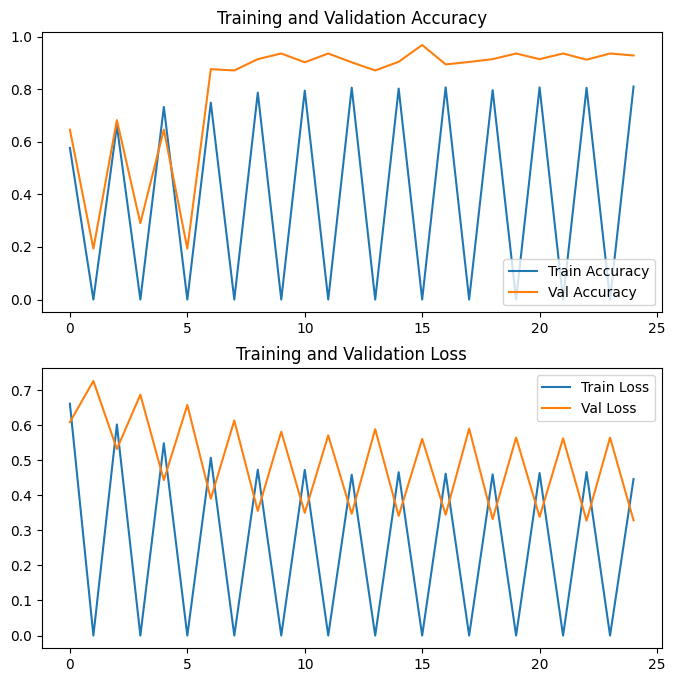

In [14]:
# Get the training and validation accuracy.
training_accuracy = history.history["accuracy"]
validation_accuracy = history.history["val_accuracy"]

# Get the training and validation loss.
training_loss = history.history["loss"]
validation_loss = history.history["val_loss"]


# Plot the learning curve.
fig, ax = plt.subplots(2, 1, figsize=(8, 8))
ax[0].plot(range(num_epochs), training_accuracy)
ax[0].plot(range(num_epochs), validation_accuracy)
ax[0].set_title("Training and Validation Accuracy")
ax[0].legend(["Train Accuracy", "Val Accuracy"], loc="lower right")

ax[1].plot(range(num_epochs), training_loss)
ax[1].plot(range(num_epochs), validation_loss)
ax[1].set_title("Training and Validation Loss")
ax[1].legend(["Train Loss", "Val Loss"], loc="upper right")

plt.show()


# Hyperparameter Tuning for CNN Architecture.

In [17]:

class CNNHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        model = Sequential()

        model.add(Conv2D(
            filters=hp.Int('conv1_filters', min_value=32, max_value=128, step=32),
            kernel_size=hp.Choice('conv1_kernel', values=[3, 5]),
            activation='relu',
            input_shape=self.input_shape
        ))
        
        model.add(Conv2D(
            filters=hp.Int('conv2_filters', min_value=32, max_value=128, step=32),
            kernel_size=hp.Choice('conv2_kernel', values=[3, 5]),
            activation='relu'
        ))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(
            filters=hp.Int('conv3_filters', min_value=64, max_value=256, step=64),
            kernel_size=hp.Choice('conv3_kernel', values=[3, 5]),
            activation='relu'
        ))

        model.add(Conv2D(
            filters=hp.Int('conv4_filters', min_value=64, max_value=256, step=64),
            kernel_size=hp.Choice('conv4_kernel', values=[3, 5]),
            activation='relu'
        ))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Dropout(hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)))

        model.add(Conv2D(
            filters=hp.Int('conv5_filters', min_value=128, max_value=512, step=128),
            kernel_size=hp.Choice('conv5_kernel', values=[3, 5]),
            activation='relu'
        ))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Dropout(hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1)))

        model.add(Flatten())

        model.add(Dense(hp.Int('dense_units', min_value=8, max_value=64, step=8), activation='relu'))

        model.add(Dropout(hp.Float('dropout_3', min_value=0.2, max_value=0.5, step=0.1)))

        model.add(Dense(1, activation='sigmoid'))

        model.compile(
            optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        return model

hypermodel = CNNHyperModel(input_shape=train_generator.image_shape)

tuner = kt.Hyperband(
    hypermodel,
    objective='val_accuracy',
    max_epochs=20,
    factor=3,
    directory='my_dir',
    project_name='cnn_hyperparameter_tuning'
)

tuner.search(train_generator, validation_data=val_generator, epochs=3, verbose=1)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Optimal Hyperparameters:\n{best_hps}")


Trial 2 Complete [01h 49m 35s]
val_accuracy: 0.8851224184036255

Best val_accuracy So Far: 0.9077212810516357
Total elapsed time: 02h 36m 53s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
128               |64                |conv1_filters
5                 |3                 |conv1_kernel
32                |64                |conv2_filters
3                 |3                 |conv2_kernel
256               |128               |conv3_filters
5                 |3                 |conv3_kernel
128               |64                |conv4_filters
5                 |3                 |conv4_kernel
0.3               |0.3               |dropout_1
384               |512               |conv5_filters
5                 |5                 |conv5_kernel
0.4               |0.4               |dropout_2
48                |64                |dense_units
0.4               |0.2               |dropout_3
0.0001            |0.001             |learning_rate
3                

KeyboardInterrupt: 

In [19]:

model = Sequential()
    
# Add convolutional layers with the best hyperparameters
model.add(Conv2D(
    filters=64,  # Best value for conv1_filters
    kernel_size=3,  # Best value for conv1_kernel
    activation='relu',
    input_shape=(train_generator.image_shape)  # Assuming input_shape is defined
))
    
model.add(Conv2D(
    filters=64,  # Best value for conv2_filters
    kernel_size=3,  # Best value for conv2_kernel
    activation='relu'
))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(
    filters=128,  # Best value for conv3_filters
    kernel_size=3,  # Best value for conv3_kernel
    activation='relu'
))

model.add(Conv2D(
    filters=64,  # Best value for conv4_filters
    kernel_size=3,  # Best value for conv4_kernel
    activation='relu'
))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.3))  # Best value for dropout_1

model.add(Conv2D(
    filters=512,  # Best value for conv5_filters
    kernel_size=5,  # Best value for conv5_kernel
    activation='relu'
))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.4))  # Best value for dropout_2

model.add(Flatten())

model.add(Dense(64, activation='relu'))  # Best value for dense_units

model.add(Dropout(0.2))  # Best value for dropout_3

model.add(Dense(1, activation='sigmoid'))


model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),  # Best value for learning_rate
    loss='binary_crossentropy',
    metrics=['accuracy']
)


model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 222, 222, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 220, 220, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 110, 110, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 108, 108, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 106, 106, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 49, 49, 512)    │       819,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 24, 24, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 24, 24, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 294912)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │    18,874,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,880,577 (75.84 MB)

 Trainable params: 19,880,577 (75.84 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Train the model over 15 epochs.
num_epochs = 15

history = model.fit(
    train_generator,
    steps_per_epoch = 42, #.samples // batch_size,
    validation_data = val_generator, 
    validation_steps = val_generator.samples // batch_size,
    epochs = num_epochs,
    verbose=1 
)

Epoch 1/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 989s 23s/step - accuracy: 0.5708 - loss: 1.5695 - val_accuracy: 0.8740 - val_loss: 0.2943
Epoch 2/15


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7742 - val_loss: 0.4347
Epoch 3/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 976s 23s/step - accuracy: 0.8796 - loss: 0.3026 - val_accuracy: 0.8720 - val_loss: 0.2630
Epoch 4/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7742 - val_loss: 0.3763
Epoch 5/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 996s 24s/step - accuracy: 0.8805 - loss: 0.2825 - val_accuracy: 0.9000 - val_loss: 0.2253
Epoch 6/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9355 - val_loss: 0.1599
Epoch 7/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 973s 23s/step - accuracy: 0.9049 - loss: 0.2347 - val_accuracy: 0.9100 - val_loss: 0.2026
Epoch 8/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9355 - val_loss: 0.1640
Epoch 9/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 985s 23s/step - accuracy: 0.9074 - loss: 0.2405 

# View the Loss History
Create plots of the loss and accuracy on the training and validation sets

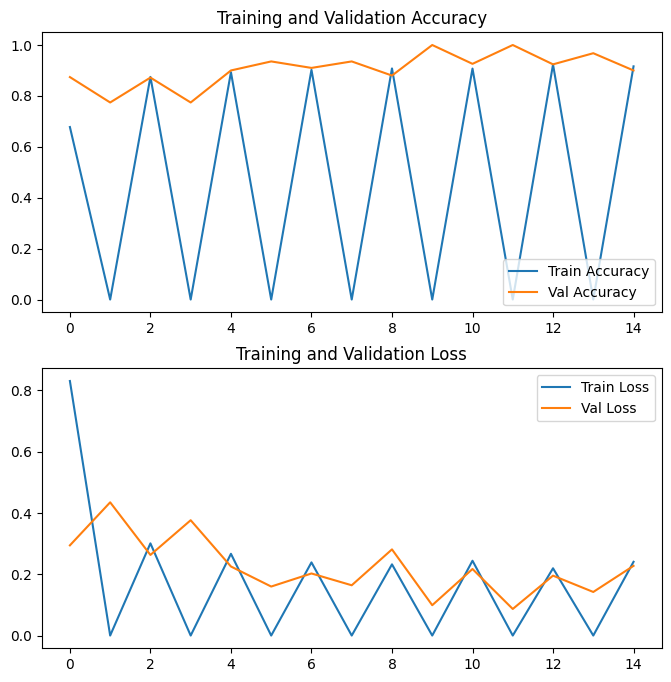

In [21]:
# Get the training and validation accuracy.
training_accuracy = history.history["accuracy"]
validation_accuracy = history.history["val_accuracy"]

# Get the training and validation loss.
training_loss = history.history["loss"]
validation_loss = history.history["val_loss"]


# Plot the learning curve.
fig, ax = plt.subplots(2, 1, figsize=(8, 8))
ax[0].plot(range(num_epochs), training_accuracy)
ax[0].plot(range(num_epochs), validation_accuracy)
ax[0].set_title("Training and Validation Accuracy")
ax[0].legend(["Train Accuracy", "Val Accuracy"], loc="lower right")

ax[1].plot(range(num_epochs), training_loss)
ax[1].plot(range(num_epochs), validation_loss)
ax[1].set_title("Training and Validation Loss")
ax[1].legend(["Train Loss", "Val Loss"], loc="upper right")

plt.show()


# Testing on Valdiation Data

In [22]:

# Make predictions on the data loaded using ImageDataGenerator
probability_prediction = model.predict(val_generator)

# Round up probabilities
val_prediction = np.round(probability_prediction)

labels = np.concatenate([val_generator[i][1] for i in range(len(val_generator))])

conf_matrix = confusion_matrix(labels, val_prediction)

print(conf_matrix)


# Assuming conf_matrix is your confusion matrix
tn, fp, fn, tp = conf_matrix.ravel()

# Compute accuracy
accuracy = accuracy_score(labels, val_prediction)

# Compute precision
precision = precision_score(labels, val_prediction)

# Compute recall
recall = recall_score(labels, val_prediction)

# Compute F1-score
f1score = f1_score(labels, val_prediction)

# Print the metrics
print("Validation Accuracy:", round(accuracy, 4))
print("Validation Precision:", round(precision, 4))
print("Validation Recall:", round(recall, 4))
print("Validation F1-score:", round(f1score, 4))

11/11 ━━━━━━━━━━━━━━━━━━━━ 68s 6s/step
[[232  13]
 [ 42 244]]
Validation Accuracy: 0.8964
Validation Precision: 0.9494
Validation Recall: 0.8531
Validation F1-score: 0.8987


# Getting Predictions from Test Data.

In [8]:
# Get test data directory.
test_data_path = "/kaggle/input/diagnosis-of-diabetic-retinopathy/test"

# ImageDataGenerator for validation data (no augmentation).
test_datagen = ImageDataGenerator(
    rescale = 1./255
)

print("Preparing Test Dataset...")

# Flow validation images in batches using val_datagen.
test_generator = test_datagen.flow_from_directory(
    directory=test_data_path,
    target_size=(224, 224),
    batch_size=50, 
    class_mode="binary",
    shuffle=False,
)

print('Test Data generators ready')


Preparing Test Dataset...
Found 231 images belonging to 2 classes.
Test Data generators ready


In [30]:

# Make predictions on the data loaded using ImageDataGenerator
probability_prediction = model.predict(test_generator)

# Round up probabilities
prediction = np.round(probability_prediction)


labels = np.concatenate([test_generator[i][1] for i in range(len(test_generator))])

conf_matrix = confusion_matrix(labels, prediction)

class_rep = classification_report(labels, prediction)

print(class_rep)


# Assuming conf_matrix is your confusion matrix
tn, fp, fn, tp = conf_matrix.ravel()

# Compute accuracy
accuracy = accuracy_score(labels, prediction)

# Compute precision
precision = precision_score(labels, prediction)

# Compute recall
recall = recall_score(labels, prediction)

# Compute F1-score
f1score = f1_score(labels, prediction)

# Print the metrics
print("Testing Accuracy:", round(accuracy, 4))
print("Testing Precision:", round(precision, 4))
print("Testing Recall:", round(recall, 4))
print("Testing F1-score:", round(f1score, 4))


5/5 ━━━━━━━━━━━━━━━━━━━━ 29s 6s/step
              precision    recall  f1-score   support

         0.0       0.82      0.96      0.88       113
         1.0       0.95      0.80      0.87       118

    accuracy                           0.87       231
   macro avg       0.88      0.88      0.87       231
weighted avg       0.89      0.87      0.87       231

Testing Accuracy: 0.8745
Testing Precision: 0.9495
Testing Recall: 0.7966
Testing F1-score: 0.8664


Text(0.5, 1.0, 'Confusion Matrix')

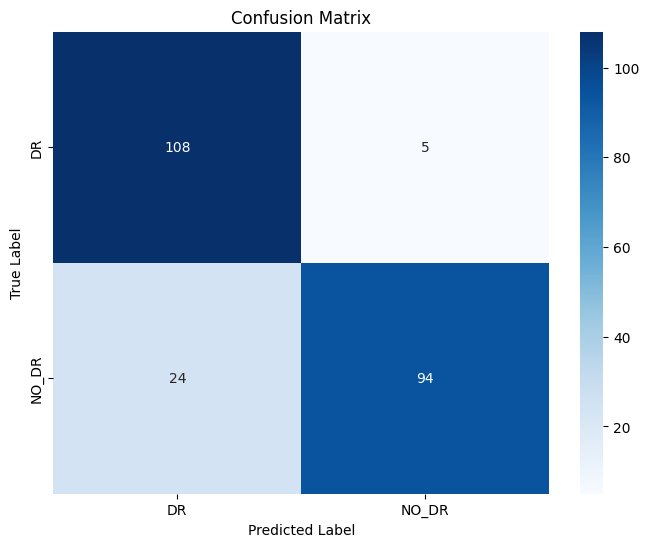

In [28]:

# Define class labels
class_labels = ['DR', 'NO_DR']

# Plot confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

# Save the Trained Model.

In [27]:
model_filename = "/kaggle/working/file/diabetic-retino-model.h5"
model.save(model_filename)

print(f"Model saved as {model_filename}")


Model saved as /kaggle/working/file/diabetic-retino-model.h5


In [9]:
from keras.models import load_model

# Load the model
model = load_model("/kaggle/working/file/diabetic-retino-model.h5")

# Make predictions on the data loaded using ImageDataGenerator
probability_prediction = model.predict(test_generator)

# Round up probabilities
prediction = np.round(probability_prediction)


labels = np.concatenate([test_generator[i][1] for i in range(len(test_generator))])

conf_matrix = confusion_matrix(labels, prediction)

class_rep = classification_report(labels, prediction)

print(class_rep)


# Assuming conf_matrix is your confusion matrix
tn, fp, fn, tp = conf_matrix.ravel()

# Compute accuracy
accuracy = accuracy_score(labels, prediction)

# Compute precision
precision = precision_score(labels, prediction)

# Compute recall
recall = recall_score(labels, prediction)

# Compute F1-score
f1score = f1_score(labels, prediction)

# Print the metrics
print("Testing Accuracy:", round(accuracy, 4))
print("Testing Precision:", round(precision, 4))
print("Testing Recall:", round(recall, 4))
print("Testing F1-score:", round(f1score, 4))

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 32s 6s/step
              precision    recall  f1-score   support

         0.0       0.82      0.96      0.88       113
         1.0       0.95      0.80      0.87       118

    accuracy                           0.87       231
   macro avg       0.88      0.88      0.87       231
weighted avg       0.89      0.87      0.87       231

Testing Accuracy: 0.8745
Testing Precision: 0.9495
Testing Recall: 0.7966
Testing F1-score: 0.8664


# Converting Keras Model to TensorFlow Lite

In [1]:

# Convert the Keras model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a file
with open('/kaggle/working/model.tflite', 'wb') as file_obj:
    file_obj.write(tflite_model)

print("Model has been converted to TensorFlow Lite file.")


Model has been converted to TensorFlow Lite file.
